In [1]:
import pandas as pd
import pingouin as pg
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt

from statsmodels.regression.mixed_linear_model import MixedLMResultsWrapper

In [3]:
# -- style
sns.set_style('whitegrid')

matplotlib.rcParams.update({
    'font.size': 10, 
    'font.family': "Helvetica"
})

In [4]:
df_survey = pd.read_csv("data/survey_data_by_evaluation.csv.tar.gz", index_col=0)
df_story = pd.read_csv("data/story_data.csv.tar.gz", index_col=0)
df_story['t'] = df_story['t'].round(3)

ids = set(df_survey['story_id'])
df = pd.merge(df_survey, df_story[df_story['story_id'].isin(ids)], on="story_id")

In [5]:
df['coherence'] = 6 - df['coherence']

### Descriptive Statistics

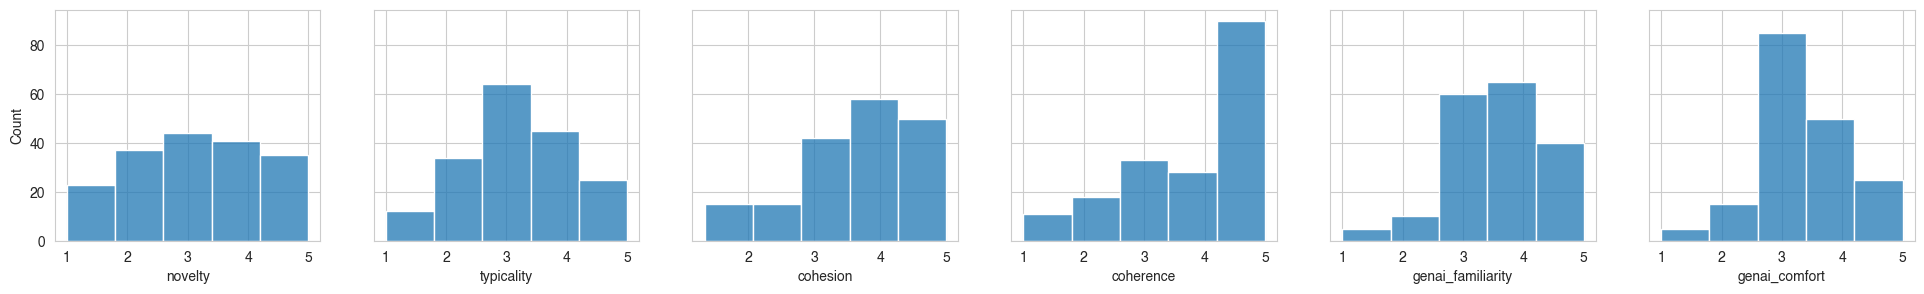

In [6]:
fig, axs = plt.subplots(1,6, figsize=(24, 3), sharey=True)
columns = ['novelty', 'typicality', 'cohesion', 'coherence', 'genai_familiarity', 'genai_comfort']
for ax, c in zip(axs, columns):
    sns.histplot(df, x=c, bins=5, ax=ax)
plt.show()

In [7]:
independent_vars = ["novelty", "typicality", "cohesion", "coherence"]
results = []
for ivar in independent_vars:        
    alpha = pg.cronbach_alpha(data=df, items="story_id", subject="participant_id", scores=ivar)
    row = [
        df[ivar].mean(),
        df[ivar].std(),
        alpha[0]
    ]
    results.append(row)

# -- append the mean alpha
results.append(["-", "-", sum(x[-1] for x in results) / 4])

index = ["Novelty", "Typicality", "Cohesion", "Coherence", "Mean"]
header = ["Mean", "Std. Dev.", "Cronbach's $\\alpha$"]
df_ds = pd.DataFrame(results, index=index, columns=header)

with open("./output/desc_stats_table.tex", "w") as f:
    df_ds.to_latex(f, float_format="{:0.3f}".format, column_format="lccc", multicolumn_format="c")

df_ds

,Mean,Std. Dev.,Cronbach's $\alpha$
Novelty,3.123739,1.165116,0.546534
Typicality,3.199483,0.98665,0.663973
Cohesion,3.689089,0.958995,0.596493
Coherence,3.870044,1.178335,0.748929
Mean,-,-,0.638982


### Linear Mixed-Effects Models

In [8]:
def r2_lme(model: MixedLMResultsWrapper) -> dict[str, float]:
    f = model.fittedvalues.var()
    r = model.cov_re.iloc[0,0]
    eps =  model.resid.var()

    return {"conditional_r2": (f + r) / (f + r + eps),
            "marginal_r2": f / (f + r + eps)}

In [9]:
independent_vars = ['novelty', 'typicality', 'cohesion', 'coherence']
dependent_vars = ['temperature', 'perplexity', 'prototype_cos_sim', 'prototype_edit_dist_norm']

results = []
for ivar in independent_vars:
    row = []
    for i, dvar in enumerate(dependent_vars):
        fm = smf.mixedlm(f"{ivar} ~ {dvar}", data=df, groups='participant_id').fit()
        r2 = r2_lme(fm)
        coef = str(round(fm.params[dvar], 2))

        for p in [0.05, 0.01, 0.001]:
            if fm.pvalues[dvar] < p:
                coef += "*"
       
        row += [fm.params[dvar], fm.bse[dvar],  r2['conditional_r2'], r2['marginal_r2']]
    results.append(row)


header = pd.MultiIndex.from_product([["Temperature", "Perplexity", "Cosine Similiarity", "Normalised Edit Distance"],
                                     [r'$\hat{\beta}$','SE','$R^2_c$', '$R^2_m$']])
df_lme = pd.DataFrame(results, index=[ivar.capitalize() for ivar in independent_vars], columns=header)

with open("./output/lme_results_table.tex", "w") as f:
    df_lme.to_latex(f, float_format="{:0.2f}".format, column_format='l|cccc|cccc|cccc|cccc', multicolumn_format="c")

df_lme

Temperature                                  Perplexity  \
           $\hat{\beta}$        SE   $R^2_c$   $R^2_m$ $\hat{\beta}$   
Novelty         0.307792  0.137565  0.384855  0.152371      0.730414   
Typicality     -0.095365  0.117867  0.338767  0.124552     -0.204806   
Cohesion       -0.181029  0.111942  0.406430  0.161481     -0.183101   
Coherence      -0.240212  0.122124  0.645610  0.283003     -0.193671   

                                         Cosine Similiarity            \
                  SE   $R^2_c$   $R^2_m$      $\hat{\beta}$        SE   
Novelty     0.273214  0.369908  0.157722          -1.082951  0.912666   
Typicality  0.237007  0.344788  0.126278          -0.987230  0.771377   
Cohesion    0.226210  0.391885  0.151484           2.088577  0.716313   
Coherence   0.250801  0.627391  0.274188           1.031781  0.788258   

                               Normalised Edit Distance                      \
             $R^2_c$   $R^2_m$            $\hat{\beta}$        SE   $R^2_c$   
Novelty     0.337937  0.129184                 2.009219  0.730681  0.377843   
Typicality  0.336479  0.127813                -0.661668  0.631638  0.336415   
Cohesion    0.430585  0.186920                -0.663004  0.608445  0.383610   
Coherence   0.628054  0.277769                -0.749570  0.663524  0.629372   

                      
             $R^2_m$  
Novelty     0.160670  
Typicality  0.125835  
Cohesion    0.151913  
Coherence   0.276260

### Plots

In [10]:
# -- get a list of all temps but the prototype.
T = list(sorted(set(df_story['t'])))[1:]

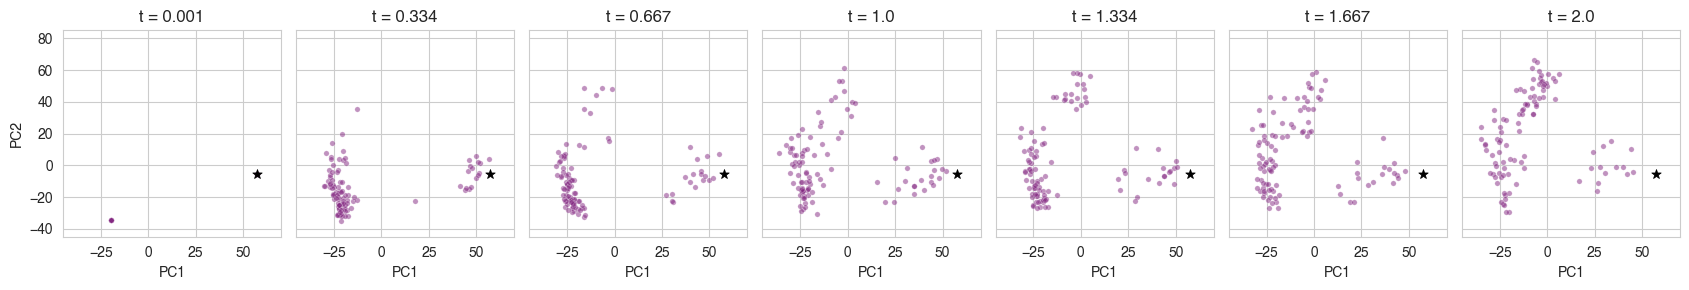

In [17]:
fig, axs = plt.subplots(1, 7, figsize=(17, 3), sharey=True)
colour = (0.512831, 0.148179, 0.507648)

for i, (t, ax) in enumerate(zip(T, axs)):
    temperature_data = df_story[df_story['t'] == t]
    sns.scatterplot(temperature_data, x="pca_x", y="pca_y", color=colour, s=15, alpha=0.5, ax=ax, legend=False)
    
    prototype_data = df_story[df_story['category'] == 'prototype']
    sns.scatterplot(prototype_data, x="pca_x", y="pca_y", marker="*", s=50, c="black", edgecolors='face', ax=ax)

    ax.set_title(f"t = {t}")
    ax.set_ylim(-45, 85)
    ax.set_xlim(-45, 70)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.savefig(f"output/pca_embeddings_per_temperature.png", dpi=600, transparent=True)
plt.show()

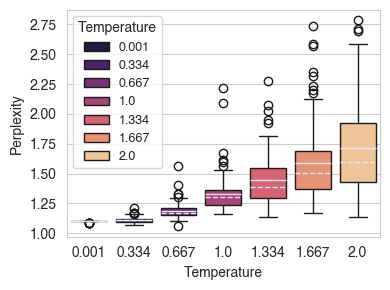

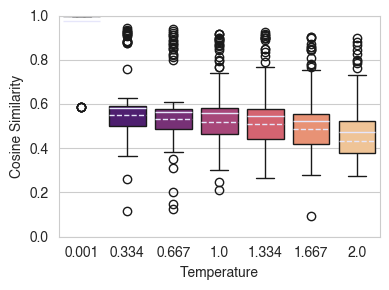

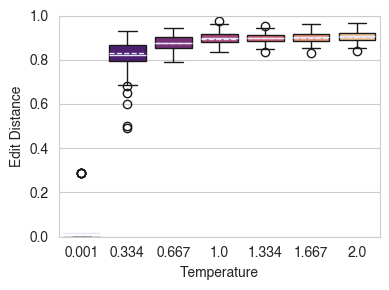

In [12]:
box_plot_style = {
    "showmeans": True, 
    "meanline": True, 
    "meanprops": {"linestyle": "-", "color": "lavender"},
    "medianprops": {"linestyle": "--", "color": "lavender"}
}
palette = sns.color_palette("magma", n_colors=7)

df_no_proto = df_story[df_story['category'] != 'prototype']


# -- PERPLEXITY
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.boxplot(df_no_proto, x="t", y="perplexity", hue="t", palette=palette, ax=ax, **box_plot_style, legend=True)
ax.set_xlabel("Temperature")
ax.set_ylabel("Perplexity")
ax.legend(prop={'size': 9})
ax.get_legend().set_title("Temperature")

plt.tight_layout()
plt.savefig(f"output/comp_eval_perplexity_write.png", dpi=600, transparent=True)


# -- COSINE SIMILARITY
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.boxplot(df_no_proto, x="t", y="prototype_cos_sim", hue="t", palette=palette, ax=ax, **box_plot_style, legend=False)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("Temperature")
ax.set_ylabel("Cosine Similarity")

plt.tight_layout()
plt.savefig(f"output/comp_eval_cossim_write.png", dpi=600, transparent=True)


# -- NORM EDIT DISTANCE
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

sns.boxplot(df_no_proto, x="t", y="prototype_edit_dist_norm", hue="t", palette=palette, ax=ax, **box_plot_style, legend=False)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel("Temperature")
ax.set_ylabel("Edit Distance")

plt.tight_layout()
plt.savefig(f"output/comp_eval_normeditdist_write.png", dpi=600, transparent=True)

plt.show()